# Predicting Telemarketing Success: Data-Driven Insights in Bank Marketing?

## **Goal**:

The objective of this project is to build a machine learning model that predicts whether a customer will subscribe to a new bank service **after being contacted** via a telemarketing campaign. By analyzing past customer interactions and demographics, the bank can:

- Measure the success probability of current contact strategies
- Prioritize follow-up actions with high-potential customers
- Reduce campaign costs by focusing on likely converters
- Improve customer targeting and campaign design

## 1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from autoviz import AutoViz_Class
import importlib
import joblib

import os
import sys
sys.path.append("../scripts")
import data_processing_framework as dpf
import ml_pipeline_utils as mlpu

import warnings
warnings.filterwarnings('ignore')

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [2]:
# Load data
train = pd.read_csv('datasets/bank_train.csv')
test = pd.read_csv('datasets/bank_test.csv')

# Display structure
print(train.info())
#print("\nMissing values:\n", train.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31648 entries, 0 to 31647
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        31648 non-null  int64 
 1   job        31648 non-null  object
 2   marital    31648 non-null  object
 3   education  31648 non-null  object
 4   default    31648 non-null  object
 5   balance    31648 non-null  int64 
 6   housing    31648 non-null  object
 7   loan       31648 non-null  object
 8   contact    31648 non-null  object
 9   day        31648 non-null  int64 
 10  month      31648 non-null  object
 11  duration   31648 non-null  int64 
 12  campaign   31648 non-null  int64 
 13  pdays      31648 non-null  int64 
 14  previous   31648 non-null  int64 
 15  poutcome   31648 non-null  object
 16  y          31648 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 4.1+ MB
None


In [3]:
train.head()

age      job      marital  education  default  balance housing loan  \
0  44     technician   single  secondary    no       29      yes    no   
1  33   entrepreneur  married  secondary    no        2      yes   yes   
2  47    blue-collar  married    unknown    no     1506      yes    no   
3  33        unknown   single    unknown    no        1       no    no   
4  35     management  married   tertiary    no      231      yes    no   

  contact   day month  duration  campaign  pdays  previous poutcome  y  
0  unknown   5    may     151        1      -1        0     unknown  0  
1  unknown   5    may      76        1      -1        0     unknown  0  
2  unknown   5    may      92        1      -1        0     unknown  0  
3  unknown   5    may     198        1      -1        0     unknown  0  
4  unknown   5    may     139        1      -1        0     unknown  0

**Column definition**

| Column        | Keep? | Reason |
|---------------|--------|--------|
| `age`         | ✅     | Customer demographic, may influence decisions |
| `job`         | ✅     | Socioeconomic indicator |
| `marital`     | ✅     | Potential lifestyle indicator |
| `education`   | ✅     | Influences financial literacy or service interest |
| `default`     | ✅     | Risk indicator |
| `balance`     | ✅     | Financial status |
| `housing`     | ✅     | Financial commitment |
| `loan`        | ✅     | Debt level |
| `contact`     | ✅     | Type of communication (e.g., cell, telephone) |
| `day`         | ✅     | Contact day of month — can affect mood/availability |
| `month`       | ✅     | Seasonality or campaign cycles |
| `duration`    | ✅     | 📌 Most predictive feature — time of contact |
| `campaign`    | ✅     | Number of contacts in this campaign |
| `pdays`       | ✅     | Days since last contact (999 = never contacted) |
| `previous`    | ✅     | Number of contacts in previous campaigns |
| `poutcome`    | ✅     | Outcome of previous campaign |

In [4]:
train.describe()

age         balance          day        duration      campaign    \
count  31648.000000   31648.000000  31648.000000  31648.000000  31648.000000   
mean      40.947769    1355.956174     15.820020    258.342518      2.759795   
std       10.610788    2990.432159      8.348106    258.558455      3.091928   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      73.000000      8.000000    103.000000      1.000000   
50%       39.000000     452.000000     16.000000    180.000000      2.000000   
75%       48.000000    1415.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

           pdays       previous          y       
count  31648.000000  31648.000000  31648.000000  
mean      40.110497      0.572580      0.117796  
std      100.208441      1.924108      0.322371  
min       -1.000000      0.000000      0.000000  
25%       -1.000000      0.000000      0.000000  
50%       -1.000000      0.000000      0.000000  
75%       -1.000000      0.000000      0.000000  
max      871.000000     58.000000      1.000000

## 2. Exploratory Data Analysis (EDA)

Shape of your Data Set loaded: (31648, 17)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : []
    Integer-Categorical Columns: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
    String-Categorical Columns: ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    Factor-Categorical Columns: []
    String-Boolean Columns: ['default', 'housing', 'loan']
    Numeric-Boolean Columns: []
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeling: []
    16 Predictors classified...
        No variables removed since no ID or low-information var

Total Number of Scatter Plots = 28
All Plots are saved in reports_html\y
Time to run AutoViz = 38 seconds 


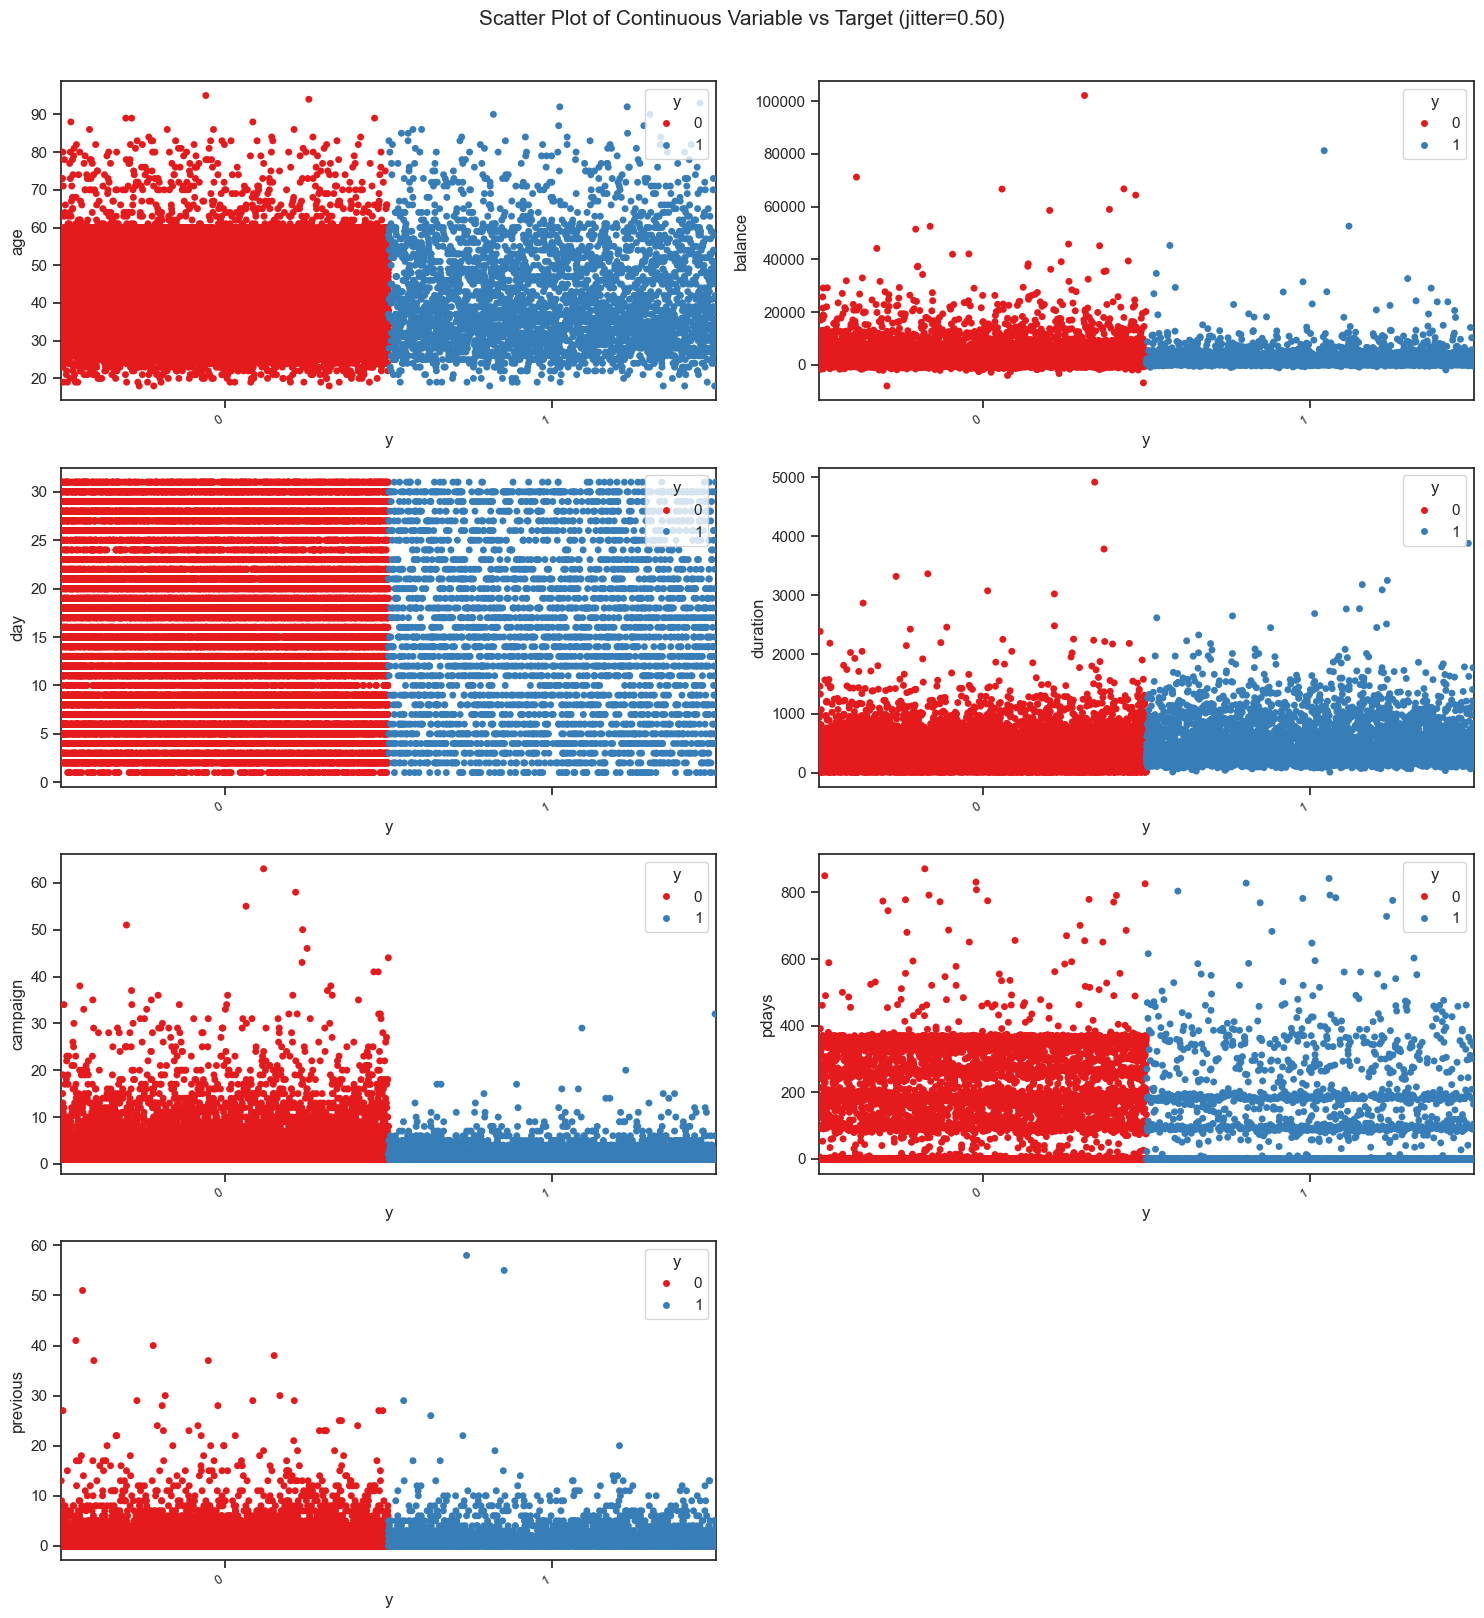

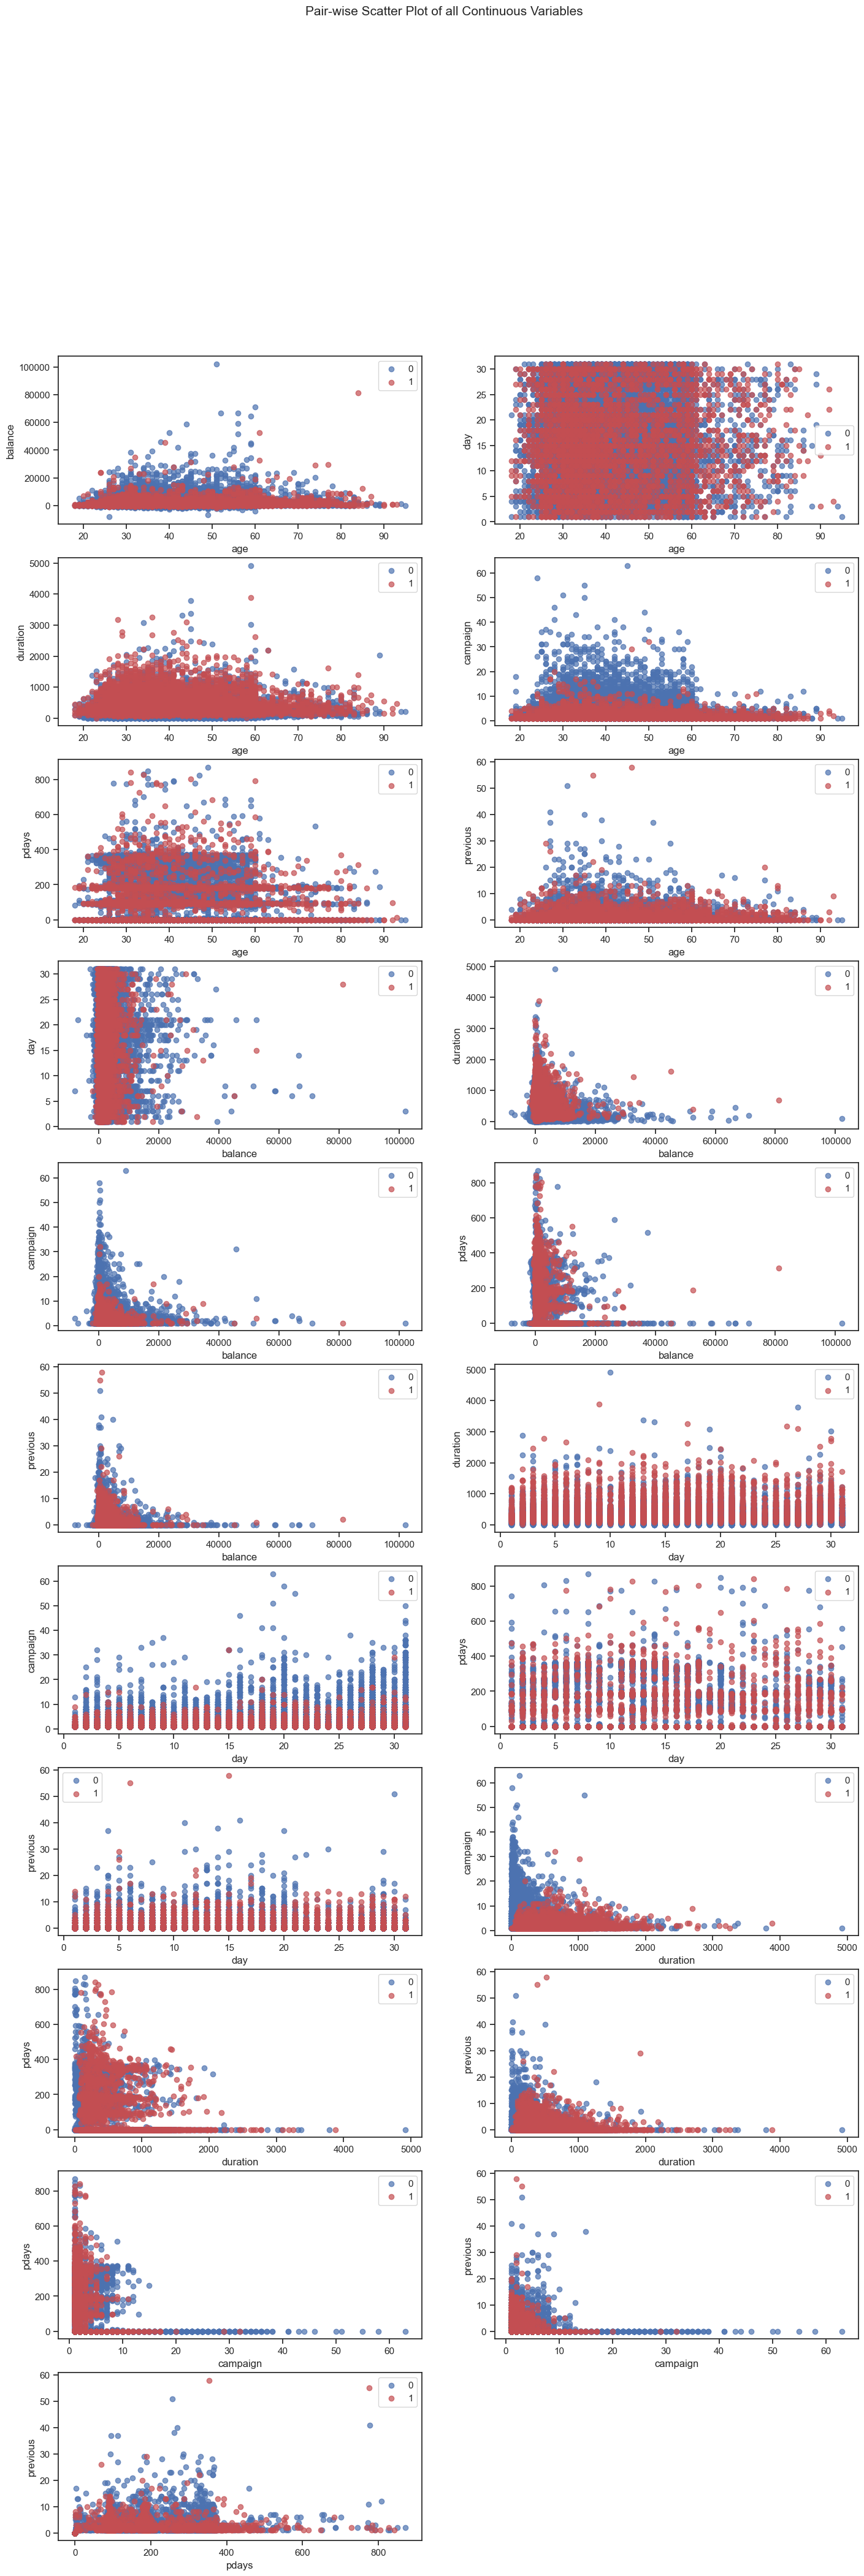

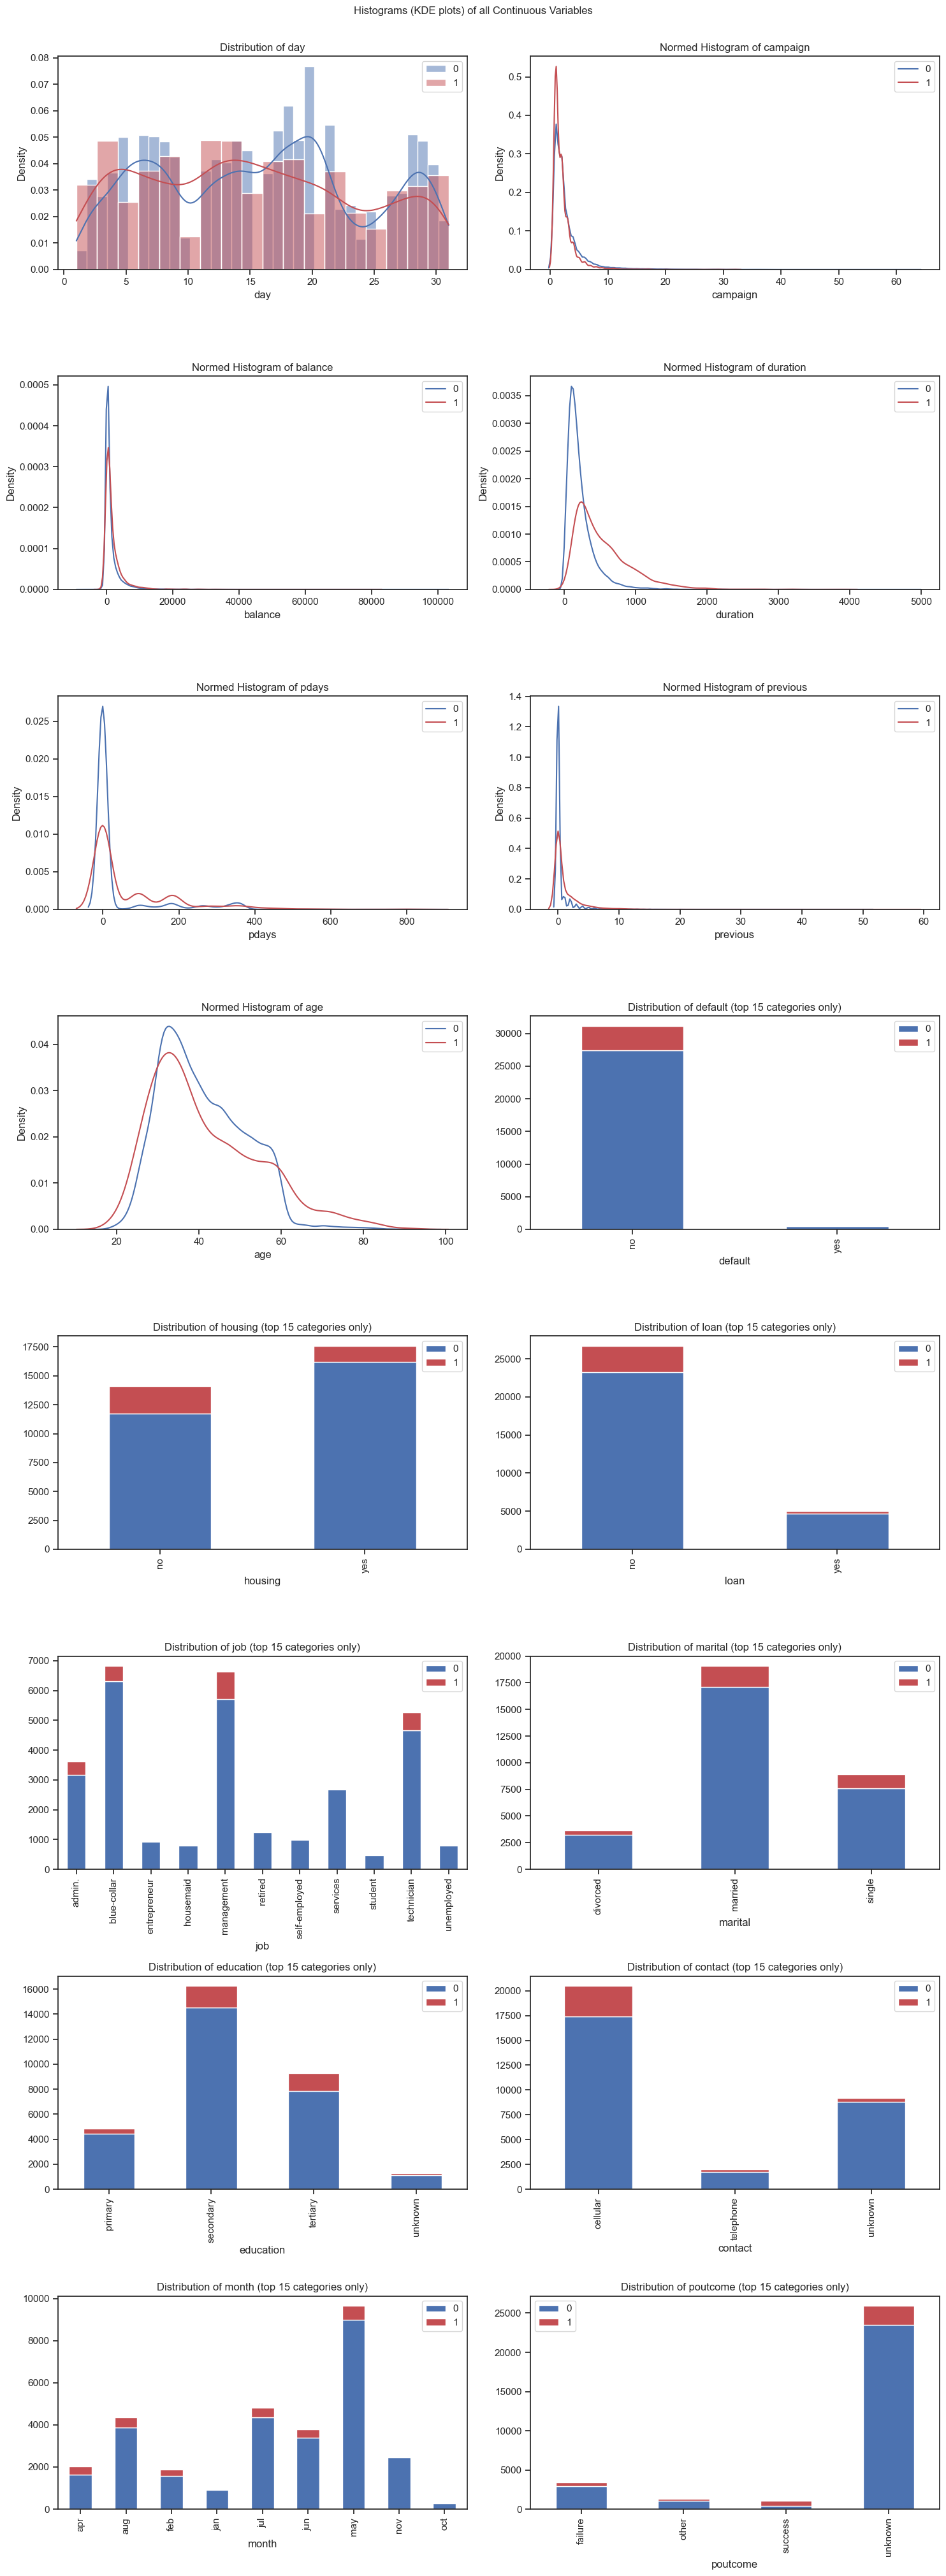

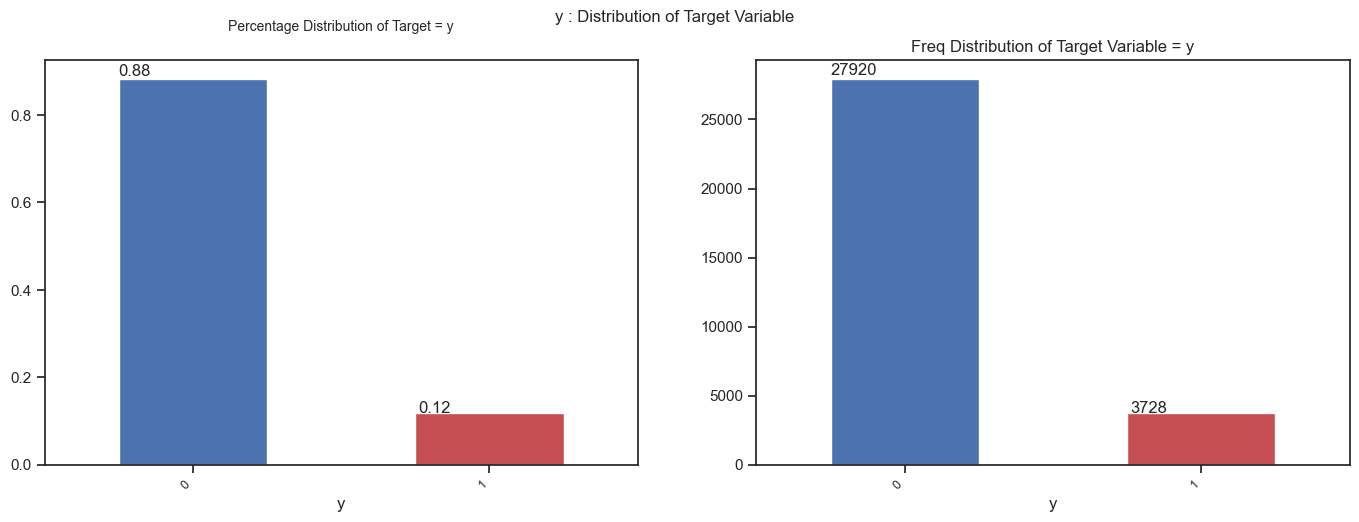

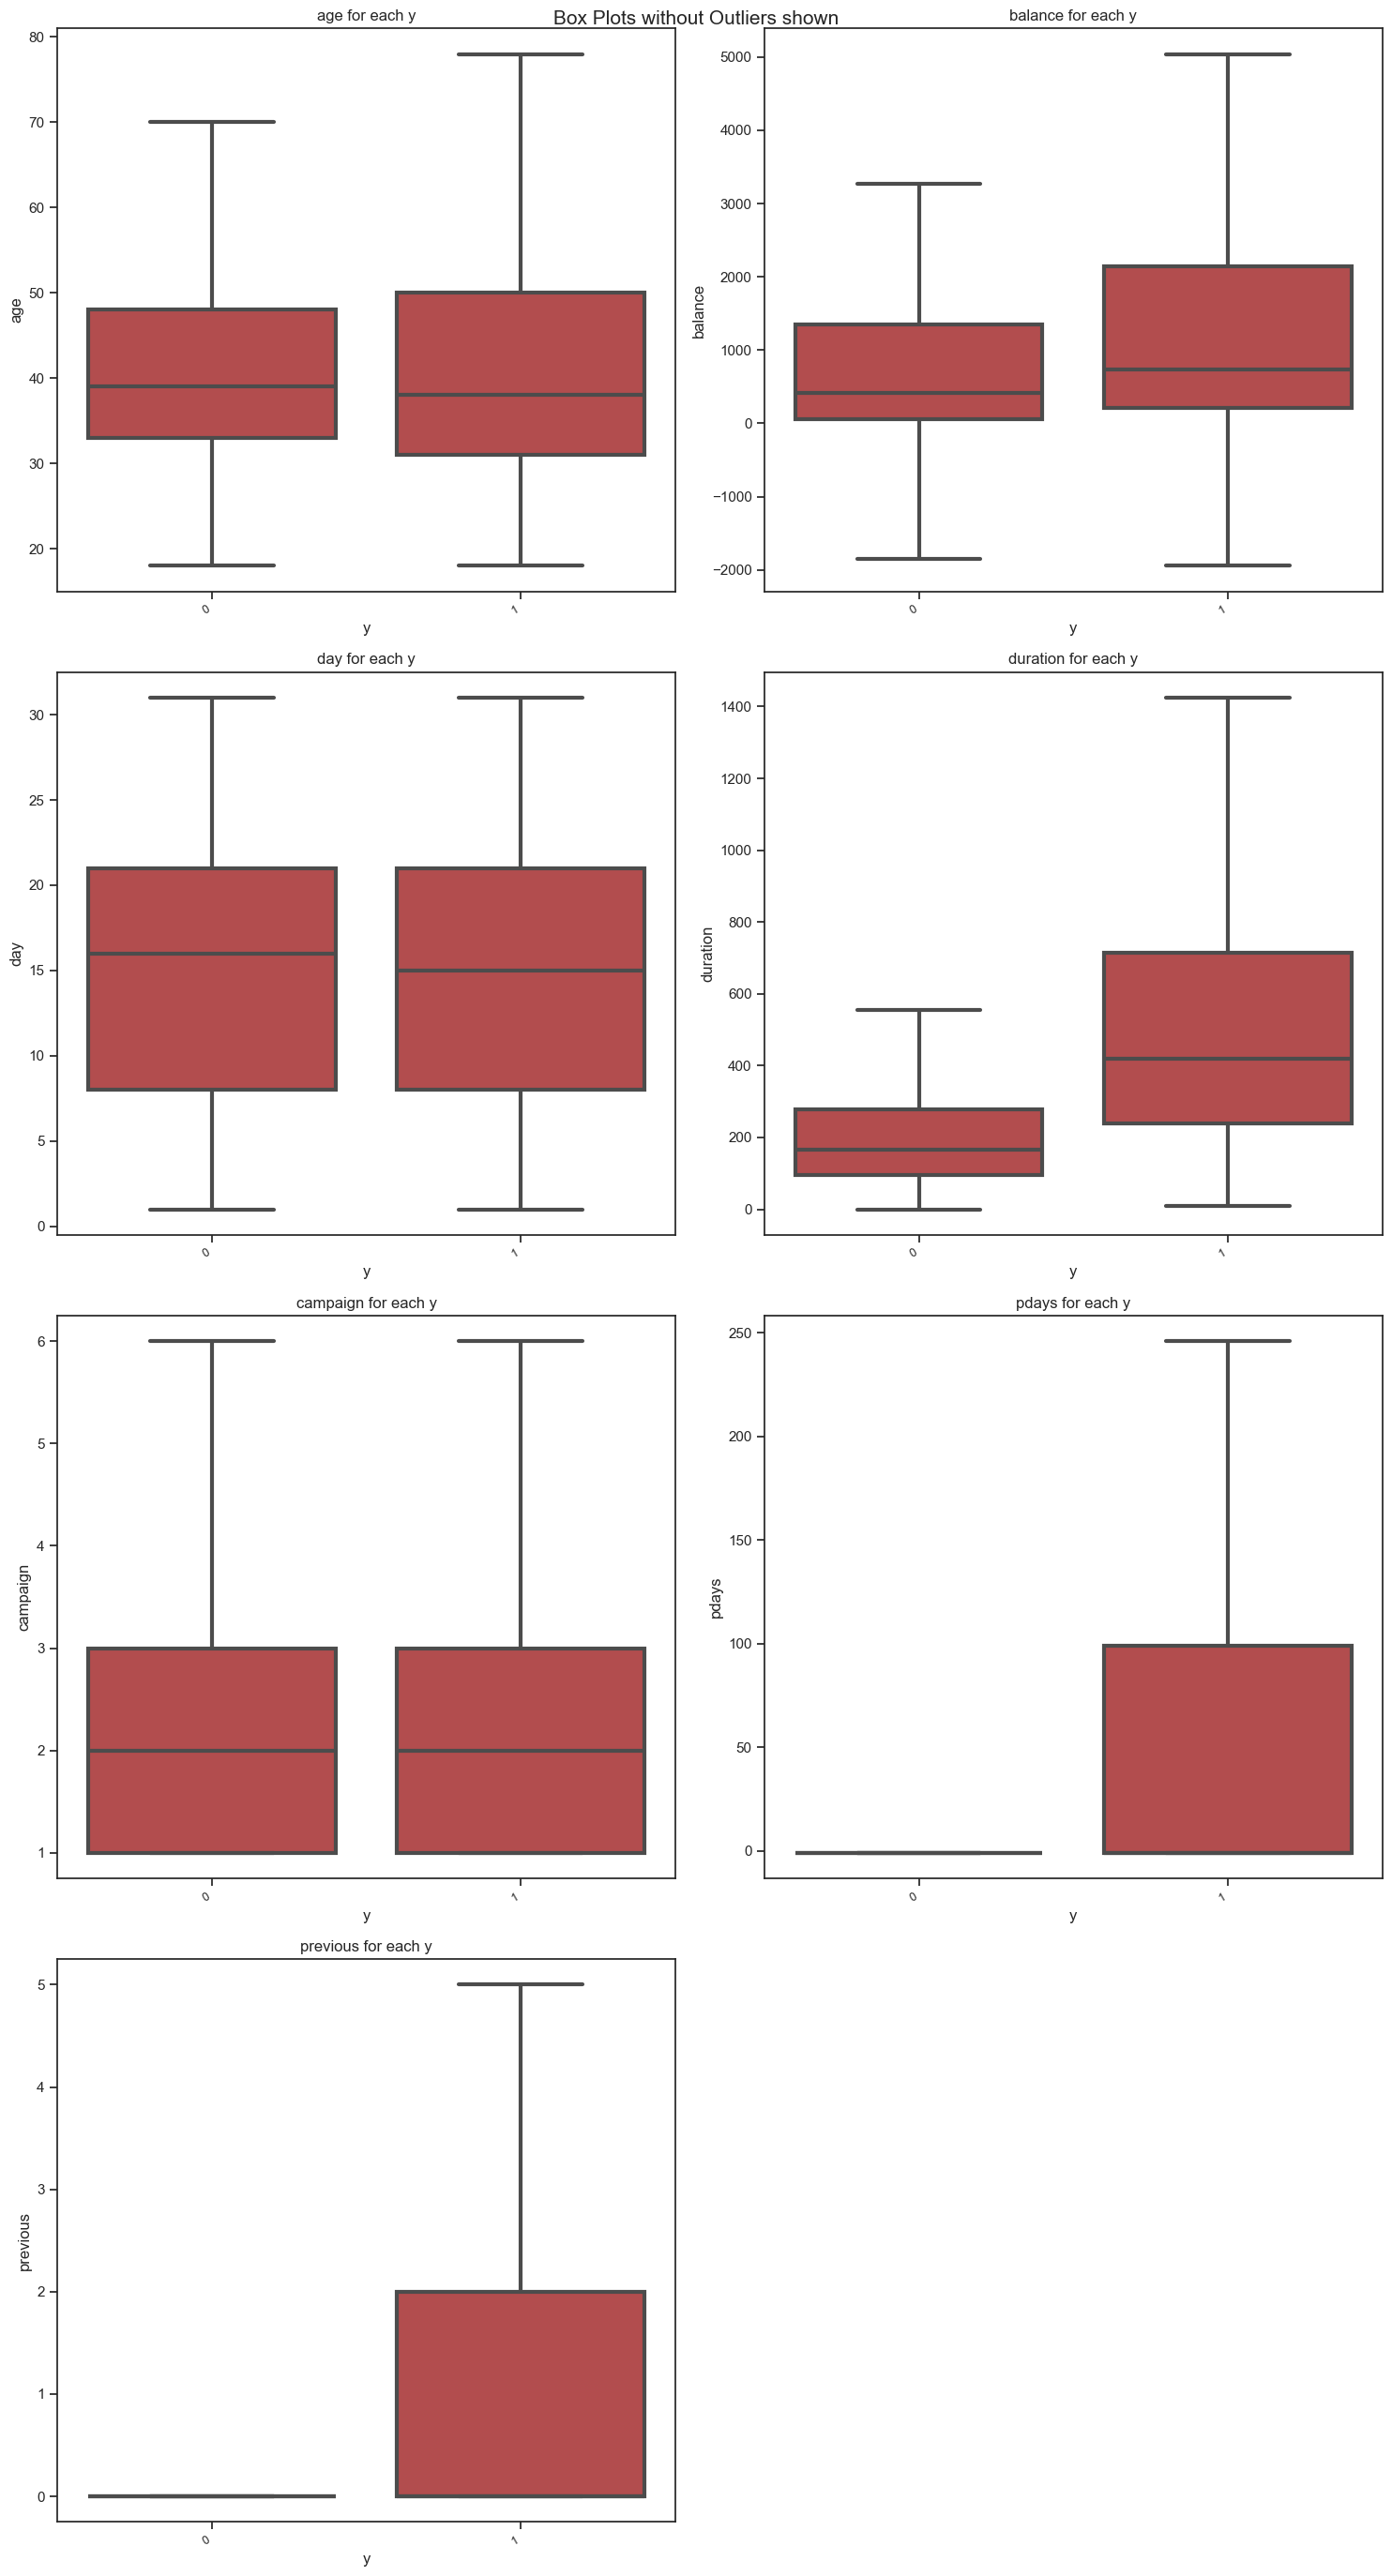

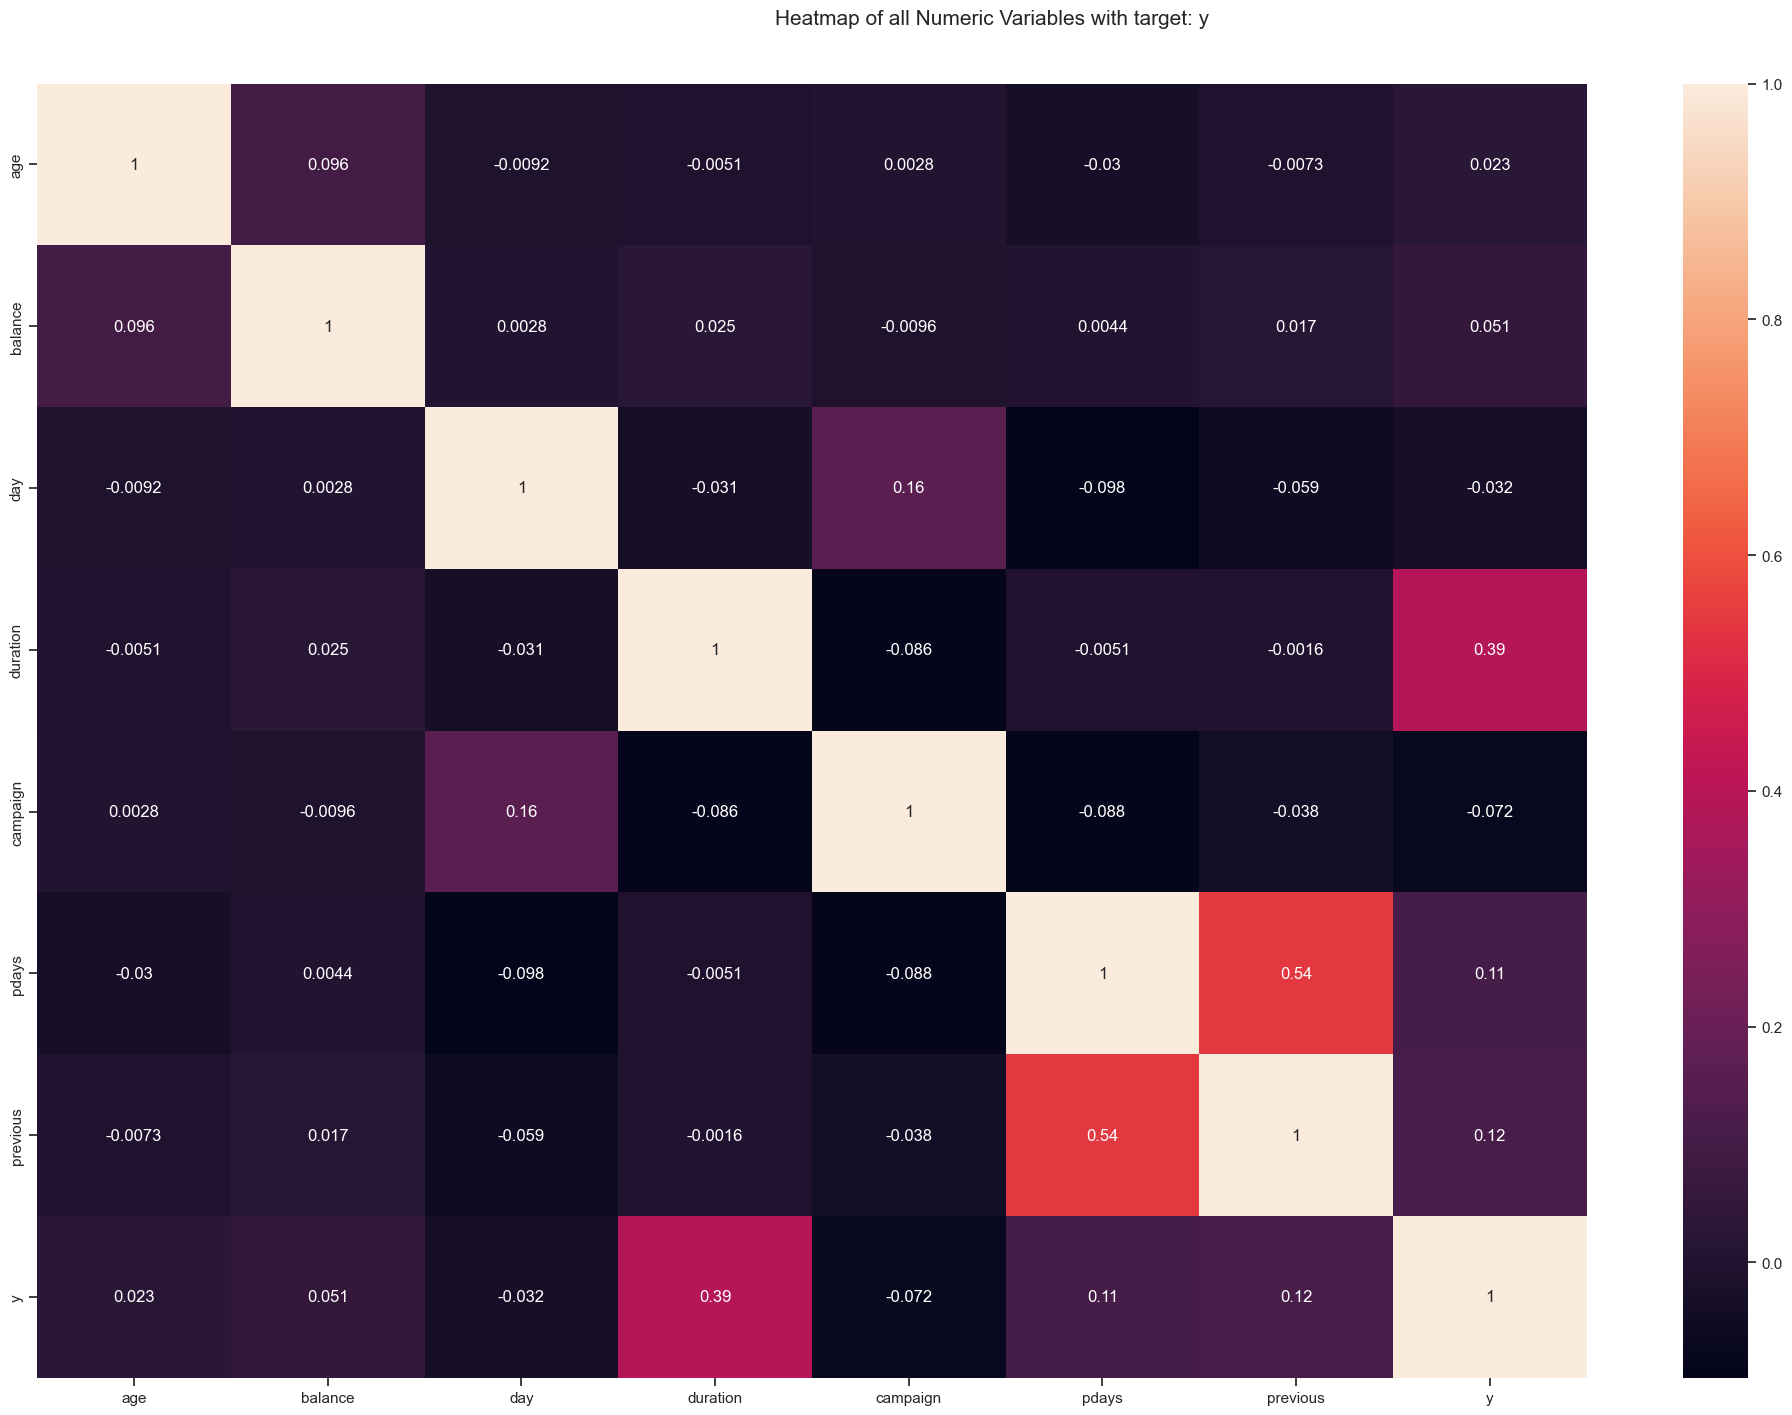

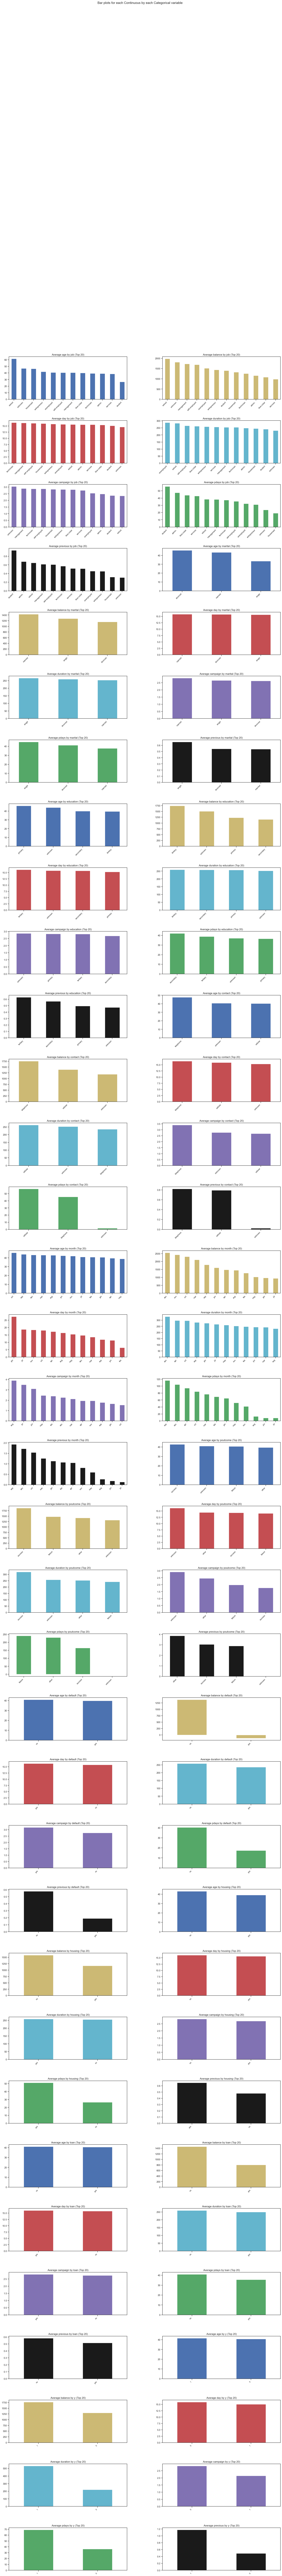

In [5]:
# Autoviz display
%matplotlib inline
AV = AutoViz_Class()
dfte = AV.AutoViz(filename="", sep=',', depVar='y', dfte=train, header=0, verbose=2, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir="reports_html")

In [9]:
#autoviz report to html
dpf.generate_autoviz_html_report(folder_name="reports_html/y", output_filename="bank_telemark_eda_report.html")

✅ AutoViz HTML report saved to: D:\Portfolio\my_projects\DataAnalysis\notebooks\reports_html\y\bank_telemark_eda_report.html


'D:\\Portfolio\\my_projects\\DataAnalysis\\notebooks\\reports_html\\y\\bank_telemark_eda_report.html'

- **Dataset Shape**: (31,648 rows, 17 columns)
- **Target Variable**: `y`(Binary Classification — 0: No, 1: Yes)
> - Class `0` (no subscription): majority class
> - Class `1` (subscription): minority class 
- **Imbalance Detected**: Class 0 (27,000+) significantly outweighs Class 1 (4,000). This imbalance can severely affect model performance:
> - Most models will lean toward predicting the majority class (`0`)
> - High accuracy might be misleading if recall or precision for class `1` is low
> - Hence, I'll be handling class imbalance before modeling
- **Feature Classification**:
  - **Continuous Integer Features**: `age`, `balance`, `day`, `duration`, `campaign`, `pdays`, `previous`
  - **Categorical Features**: `job`, `marital`, `education`, `contact`, `month`, `poutcome`
  - **Boolean Features**: `default`, `housing`, `loan`

**The correlation analysis shows that:**

- `duration` has the highest correlation with `y` (0.39), and will be included in the model.
- - Features like `previous`, `pdays`, `balance`, and `campaign` show useful signals and will be included in the model.

This insight will allow us to focus only on features available **before** initiating customer contact.

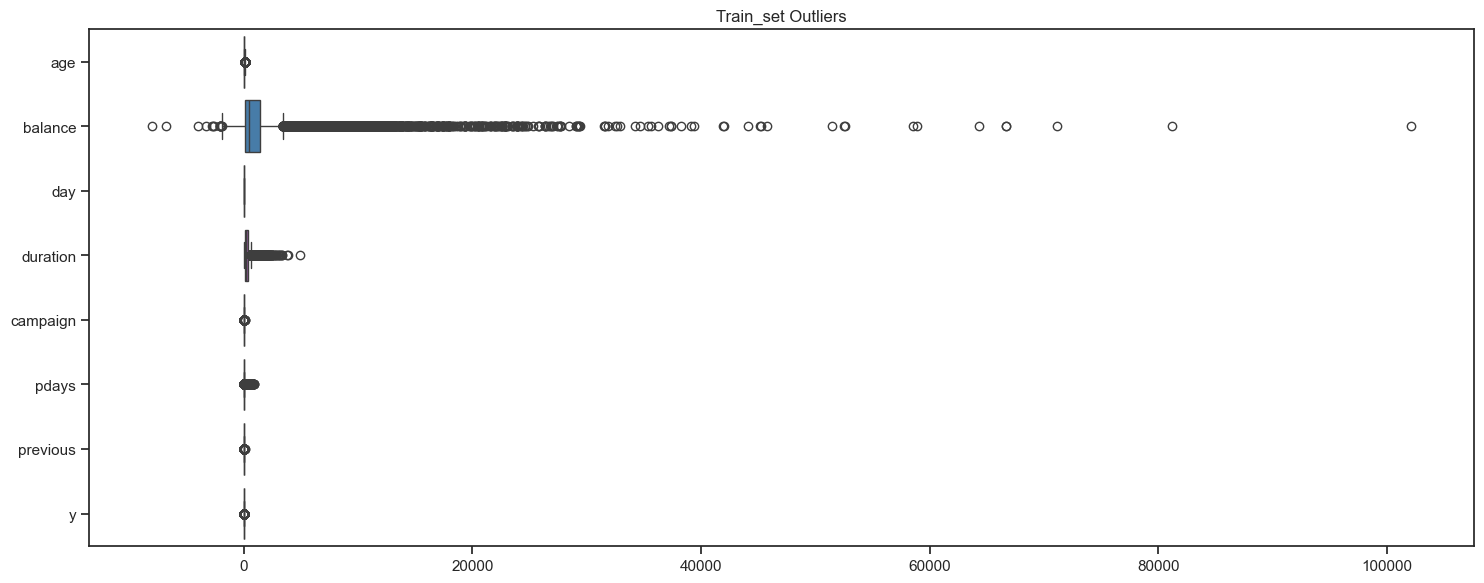

In [7]:
# plot outliers across all numeric columns using IQR
dpf.plot_outliers_boxplot(train, title="Train_set Outliers")

**Outlier Check Summary**
- **balance**: Has some extreme positive outliers > 80,000
- **duration**: Shows very high call durations > 4,000 seconds (can be valid but unusual)
- **pdays**: Outliers above 600 days since last contact
- **campaign / previous**: Some users contacted 40+ times — very unusual behavior
- **age**: Reasonable range overall, but potential concentration differences across classes

## 3. Data Preprocessing

In [8]:
# Check for full-row duplicates 
duplicates = train.duplicated().sum()
print(f" Duplicate rows : {duplicates}")

 Duplicate rows : 0


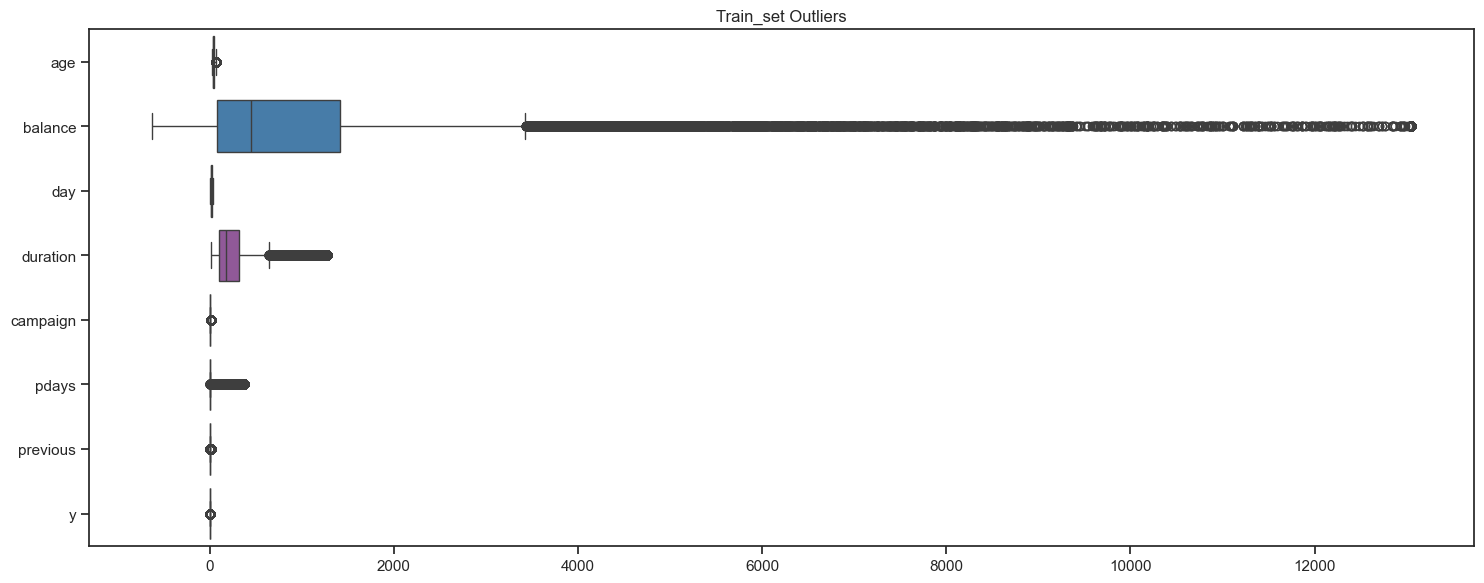

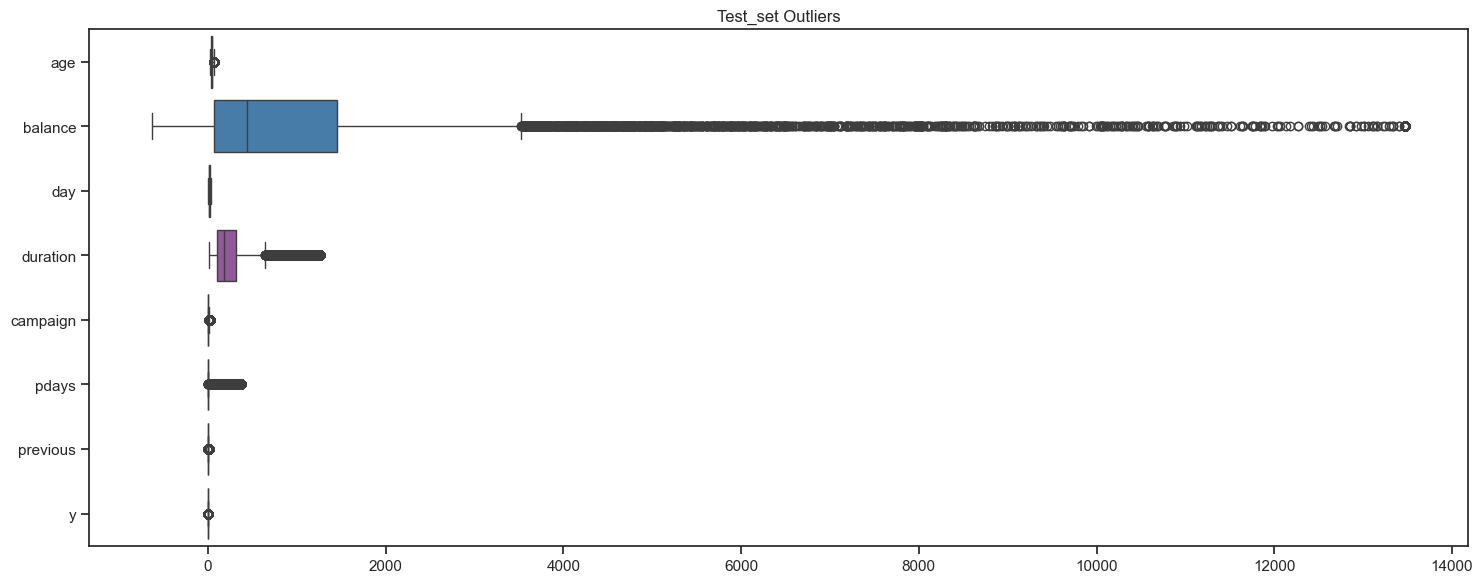

In [9]:
# Apply Winsorization to both train and test sets
train = dpf.winsorize_dataframe(train)
test = dpf.winsorize_dataframe(test)
dpf.plot_outliers_boxplot(train, title="Train_set Outliers")
dpf.plot_outliers_boxplot(test, title="Test_set Outliers")

In [10]:
# Strip whitespace from all object columns
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].str.strip().str.lower()  # convert to lowercase for consistency

In [11]:
# Check unique values
for col in train.select_dtypes(include='object').columns:
    print(f"{col}: {train[col].unique()}")

job: ['technician' 'entrepreneur' 'blue-collar' 'unknown' 'management'
 'retired' 'admin.' 'services' 'self-employed' 'housemaid' 'unemployed'
 'student']
marital: ['single' 'married' 'divorced']
education: ['secondary' 'unknown' 'tertiary' 'primary']
default: ['no' 'yes']
housing: ['yes' 'no']
loan: ['no' 'yes']
contact: ['unknown' 'cellular' 'telephone']
month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
poutcome: ['unknown' 'failure' 'success' 'other']


### Feature Importance & Engineering

- **Feature Importance** (from RF & MI):
  - Top predictive features include: `duration` (tenure), `balance`, `month`, `day`, `age`, `poutcome`, and `pdays`
  - `duration`: Time spent during the customer contact; most predictive feature
- Suitable for evaluating campaign effectiveness and customer engagement

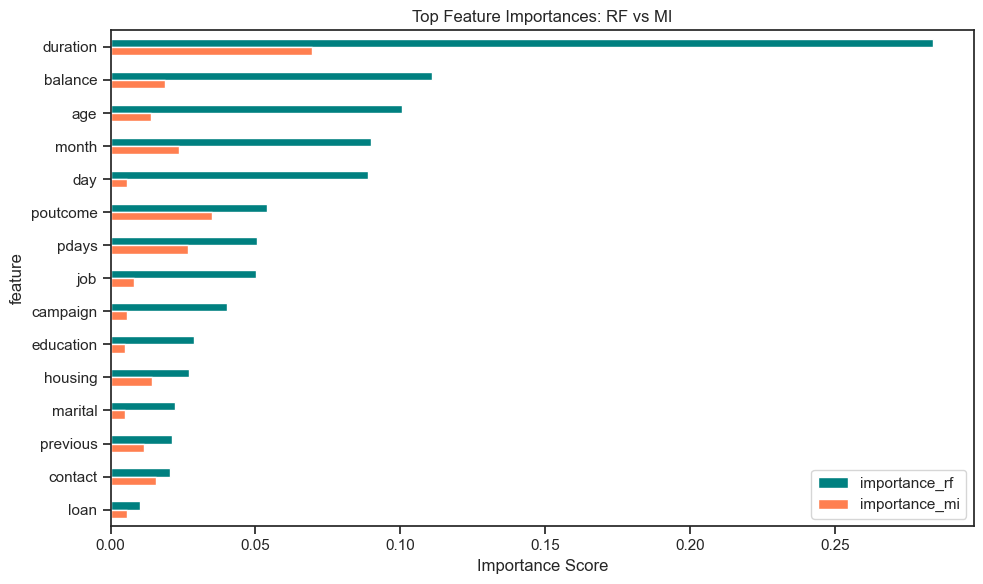

In [12]:
# feature importance
importance_df = mlpu.compute_combined_feature_importance(train, target_column='y', top_n=15, plot=True)
#print(importance_df)

In [13]:
# Encode categorical and boolean variables (label encoding and one-hot encoding).
X_train, y_train = mlpu.prepare_features(
    train,
    target_column='y',
    drop_columns=[]
)

X_test, y_test = mlpu.prepare_features(
    test,
    target_column='y',
    drop_columns=[]
)

In [14]:
# scale for numerical attributes 
X_train_scaled, X_test_scaled, pipeline = mlpu.scale_train_test(X_train, X_test)

In [15]:
y_train.value_counts()

y
0    27920
1     3728
Name: count, dtype: int64

In [16]:
y_test.value_counts()

y
0    12002
1     1561
Name: count, dtype: int64

### Handling Class Imbalance (SMOTE)

In [17]:
# Balance the training set
X_train_resampled, y_train_resampled = mlpu.balance_classes_smote(X_train, y_train)
print(y_train_resampled.value_counts())

y
0    27920
1    27920
Name: count, dtype: int64


## 4. Modeling Approach (Training & Evaluation)

In [18]:
# Train and evaluate models
selected = ["Dummy","Logistic Regression", "Naive Bayes", "Random Forest","Decision Tree","Neural Network"]
results, trained_models =  mlpu.train_and_evaluate_models(X_train_resampled, y_train_resampled, selected_models=selected)


Evaluating: Dummy
Evaluating: Logistic Regression
Evaluating: Random Forest
Evaluating: Naive Bayes
Evaluating: Decision Tree
Evaluating: Neural Network


In [19]:
# Observe Metrics
summary_df = mlpu.results_to_dataframe(results)
summary_df

Model           ROC AUC  Accuracy  Precision (1)  Recall (1)  \
0                Dummy  0.500000  0.500000    0.000000      0.000000    
1  Logistic Regression  0.914907  0.848908    0.835416      0.869019    
2        Random Forest  0.983577  0.934223    0.914947      0.957450    
3          Naive Bayes  0.872371  0.780176    0.716816      0.926289    
4        Decision Tree  0.897385  0.897976    0.887471      0.911533    
5       Neural Network  0.898932  0.837249    0.808035      0.884670    

   F1-score (1)  
0    0.000000    
1    0.851886    
2    0.935716    
3    0.808200    
4    0.899341    
5    0.844618

### Compare and Visualize

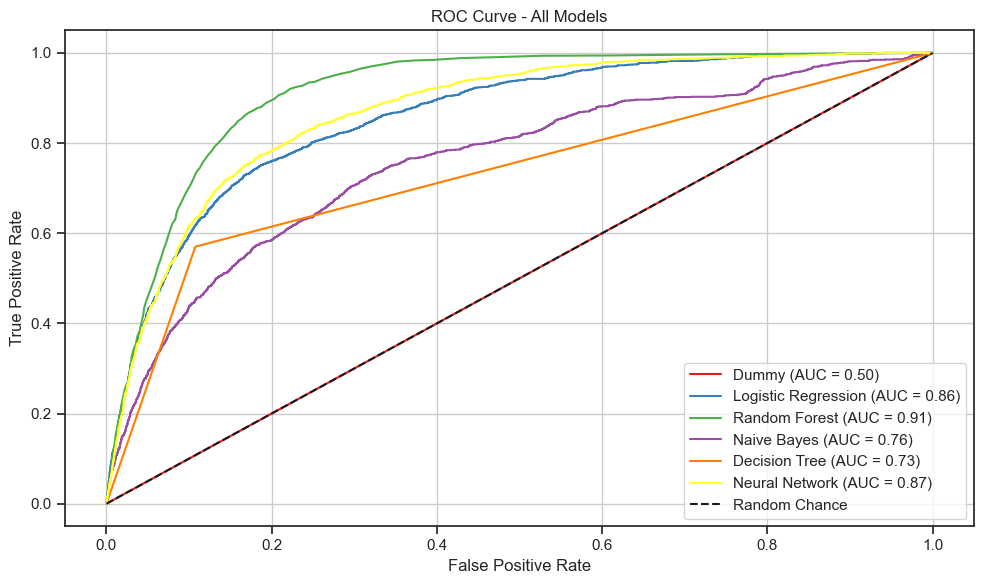

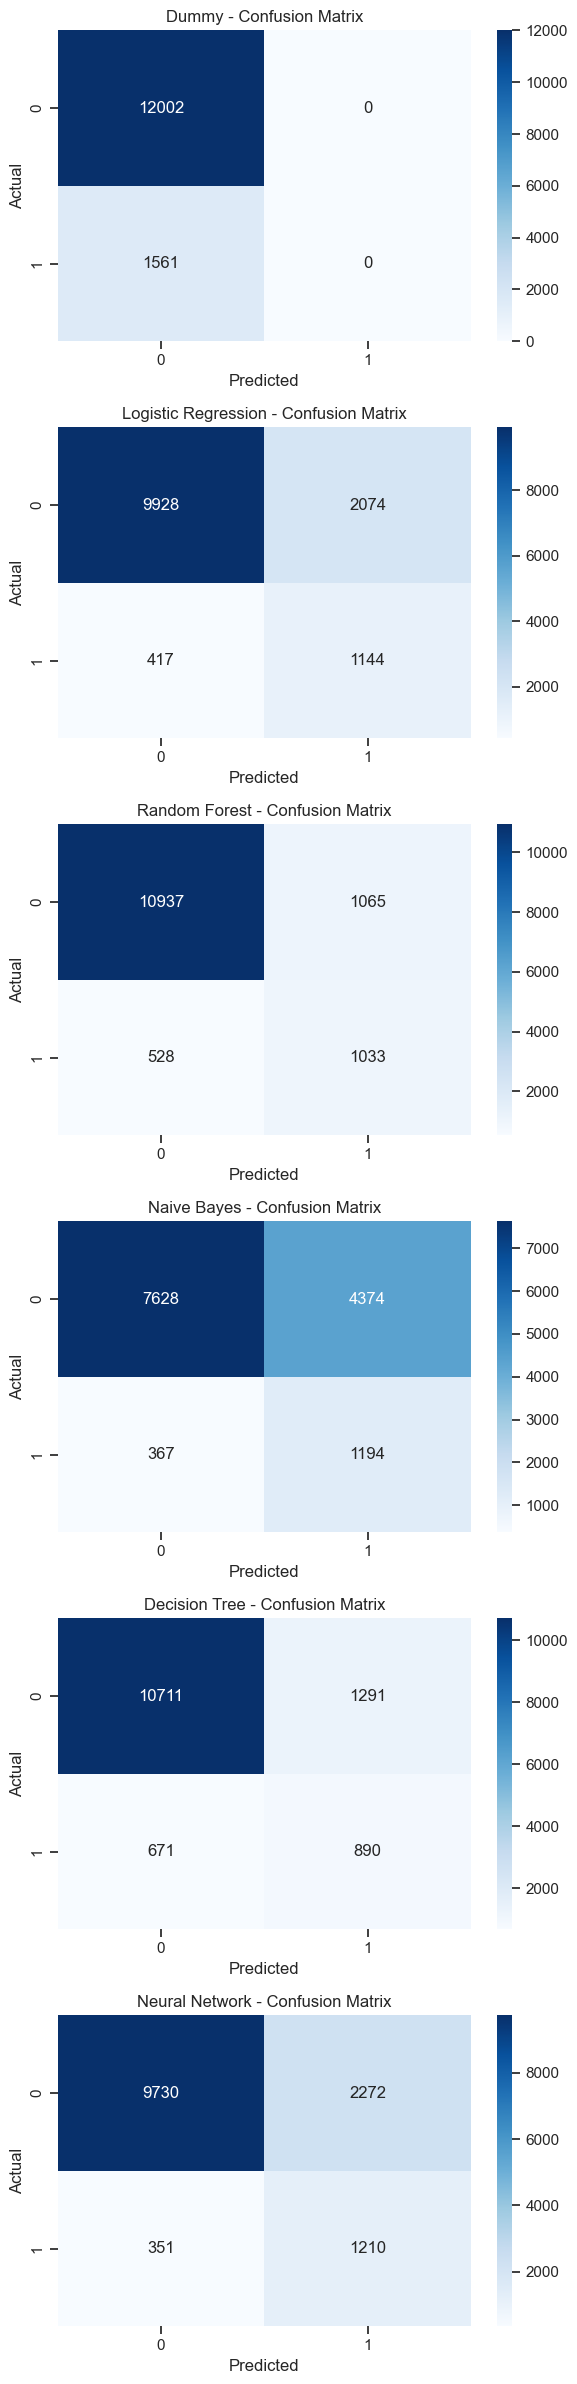

In [20]:
# plt model metric
mlpu.plot_model_evaluations(trained_models, X_test, y_test)

### Model Evaluation and Selection 

**Best Evaluation Metrics for This Objective**

- **Objective**: Predict if a customer will subscribe **after contact** to optimize telemarketing efforts.
- **Problem Type**: Binary classification with **class imbalance** (more `0`s than `1`s)

**Recommended Metrics:**
- **ROC-AUC**: Best for overall model ranking and handling imbalance.
- **F1-Score**: Balances precision and recall — great for imbalanced data.
- **Precision**: Useful if false positives are costly (e.g., wasting follow-ups).
- **Recall**: Important if missing actual subscribers is worse.
- **PR-AUC**: Optional but powerful alternative to ROC-AUC for imbalanced cases.

I'll Use **ROC-AUC for model selection**, and **F1/Precision/Recall for performance trade-off insight**.

**Insights**

- **Random Forest** outperforms all other models with the highest ROC AUC (0.984), accuracy (93.4%), and strong precision-recall balance.
- **Logistic Regression** offers competitive performance with simpler interpretability — a good choice for explainable models.
- **Naive Bayes** has high recall but lower precision, which may result in more false positives.
- **Dummy classifier** (baseline) confirms the model adds significant predictive value beyond random guessing.

Sensitivity (Recall) is an important metric for classification tasks where the positive class is relatively rare — as is the case in this telemarketing scenario. In the current banking environment, where the priority is to **maximize the number of successful subscriptions**, a model with higher sensitivity is preferable. This may come at the cost of contacting some customers who ultimately will not subscribe (i.e., false positives), but it ensures fewer missed opportunities among those who would have converted.

Given this context, the **Random Forest model** not only has the **highest recall (95.7%)**, but also outperforms Naive Bayes across all key metrics, including precision, F1-score, and ROC AUC. However, in scenarios where **speed, simplicity, and ease of deployment** are more critical than marginal gains in performance, **Naive Bayes** may still be a practical alternative — especially when computational resources are limited or when real-time predictions are needed.

### Model Tuning using RandomizedSearchCV 

In [21]:
#Tune selected models and save best model
models_and_params = mlpu.load_models_and_params() # Load all models and params

# Pick specific models to tune
selected = ["Naive Bayes", "Random Forest", "Decision Tree"]
selected_models_and_params = {
    name: models_and_params[name] for name in selected
    }

In [22]:
best_model, best_name, best_scores = mlpu.tune_and_select_best_model(
    X_train, y_train,
    models_and_params=selected_models_and_params,
    save_path="models/best_telemarketing_model.pkl"
)

🔍 Tuning Naive Bayes...
 ✅ Naive Bayes Best Recall: 0.4682 | F1: 0.4136 | Params: {}
🔍 Tuning Random Forest...
 ✅ Random Forest Best Recall: 0.5377 | F1: 0.6197 | Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
🔍 Tuning Decision Tree...
 ✅ Decision Tree Best Recall: 0.4798 | F1: 0.5811 | Params: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}

🏆 Selected Model: Random Forest | Recall: 0.5377 | F1: 0.6197
💾 Best model saved to: best_telemarketing_model.pkl


# Business Summary & Recommendations

In [41]:
# Load the best saved model
best_model = joblib.load("best_telemarketing_model.pkl")
# Use the dynamic name of the best model (assume best_name is available)
tn, fp, fn, tp = sum(results[best_name]['confusion_matrix'], [])

# Optional: Print for confirmation
print(f"✅ Best Model: {best_name}")
print(f"""
**Actionable Insights**:
- Target customers predicted as 'subscribe' (TP): {tp} (high conversion probability)
- Avoid customers predicted as 'not subscribe' (TN): {tn} (reduces unnecessary calls)
- Investigate false negatives (FN): {fn} (missed opportunities)
- Reduce false positives (FP): {fp} (cost savings)
""")

✅ Best Model: Random Forest

**Actionable Insights**:
- Target customers predicted as 'subscribe' (TP): 26732 (high conversion probability)
- Avoid customers predicted as 'not subscribe' (TN): 25435 (reduces unnecessary calls)
- Investigate false negatives (FN): 1188 (missed opportunities)
- Reduce false positives (FP): 2485 (cost savings)



# Corporate Purpose and limitations of the study.

Based on the confusion matrix results, the bank can assess model performance and make informed decisions on how to allocate campaign resources. Specifically, it can prioritize customers predicted to subscribe (true positives) and explore those who actually subscribed but were not flagged by the model (false negatives), helping to capture missed opportunities and boost revenue. At the same time, the bank can reduce unnecessary outreach by avoiding customers predicted not to subscribe (true negatives), thereby lowering campaign costs and improving efficiency.